<a href="https://colab.research.google.com/github/Kuzay3t/3D_Image_Reconstruction/blob/main/3d_Reconstruction_mscp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
!pip install open3d

In [62]:
import pandas as pd
import zipfile
import os
from google.colab import drive
import zipfile
import open3d as o3d
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


In [63]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [64]:
print(os.listdir('/content/drive/My Drive'))

['FINANCIAL LITERACY CERTIFICATE.pdf', 'KUZAYET BMC.pdf', 'GST 208 RECEIPT.pdf', 'VID-20240508-WA0014.mp4', 'BAGAI GLORY RESUME.pdf', 'BAGAI GLORY HEADSHOT.jpeg', '300LVL 2ND SEMESTER', 'project proposal template', 'RENUE DOCUMENT', 'Colab Notebooks', 'archive (1).zip', 'archive.zip']


In [65]:
zip_path = '/content/drive/My Drive/archive.zip'


In [66]:
extract_path = '/content/ModelNet10'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [67]:
print(os.listdir('/content/ModelNet10'))

['metadata_modelnet10.csv', 'ModelNet10']


**Loading Files**

In [68]:
def read_off(file_path):
    """
    Reads a .off file and returns the vertices and faces as numpy arrays.
    """
    with open(file_path, 'r') as f:
        if 'OFF' != f.readline().strip():
            raise ValueError('Not a valid OFF file')

        # Read counts
        n_verts, n_faces, _ = map(int, f.readline().strip().split())
        vertices = []
        faces = []

        # Read vertices
        for _ in range(n_verts):
            vertex = list(map(float, f.readline().strip().split()))
            vertices.append(vertex)

        # Read faces
        for _ in range(n_faces):
            parts = list(map(int, f.readline().strip().split()))
            faces.append(parts[1:])  # skip the first value (face length)

    return np.array(vertices), np.array(faces)


**Visualising Models**

In [69]:

def visualize_3d(vertices):
    """
    Visualize 3D points using matplotlib.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2])
    plt.title("3D Point Cloud")
    plt.show()


In [70]:
# normalizing vertices

def normalize(vertices):
    """
    Normalize point cloud to zero mean and unit scale.
    """
    centroid = np.mean(vertices, axis=0)
    vertices -= centroid
    scale = np.max(np.linalg.norm(vertices, axis=1))
    vertices /= scale
    return vertices


In [71]:
# adding noise

def add_noise(vertices, noise_strength=0.02):
    """
    Adds Gaussian noise to vertices.
    """
    noise = np.random.normal(0, noise_strength, vertices.shape)
    return vertices + noise


In [72]:
# converting to voxels

def pointcloud_to_voxel(points, grid_size=32):
    """
    Converts point cloud to voxel grid.
    """
    voxel_grid = np.zeros((grid_size, grid_size, grid_size))

    # Normalize to [0, grid_size - 1]
    scaled = (points + 1) * (grid_size - 1) / 2
    indices = scaled.astype(int)

    for x, y, z in indices:
        if 0 <= x < grid_size and 0 <= y < grid_size and 0 <= z < grid_size:
            voxel_grid[x, y, z] = 1.0

    return voxel_grid


In [73]:
# building the CNN Architecture

import torch
import torch.nn as nn
import torch.nn.functional as F

class DenoisingCNN(nn.Module):
    def __init__(self):
        super(DenoisingCNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv3d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(2),
            nn.Conv3d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(2)
        )
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv3d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv3d(32, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [80]:
# preparing the dataset

import torch.utils.data as data
from torch.utils.data import random_split

class VoxelDataset(data.Dataset):
    def __init__(self, clean, noisy):
        self.clean = torch.tensor(clean, dtype=torch.float32)
        self.noisy = torch.tensor(noisy, dtype=torch.float32)

    def __len__(self):
        return len(self.clean)

    def __getitem__(self, idx):
        return self.noisy[idx], self.clean[idx]

# Placeholder tensors for demonstration. Replace with actual data loading.
# These dimensions are just examples, adjust based on your actual voxel data shape (batch_size, channels, depth, height, width)
# Using torch.rand to ensure values are between 0 and 1 for BCELoss target
X_clean = torch.rand(20, 1, 32, 32, 32)  # Example: 20 samples of 32x32x32 voxels with 1 channel
X_noisy = torch.randn(20, 1, 32, 32, 32) # Example: 20 samples of 32x32x32 voxels with 1 channel

full_dataset = VoxelDataset(X_clean, X_noisy)

# Split dataset into training and testing sets
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

loader = data.DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=8, shuffle=False)

/tmp/ipython-input-80-254069255.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.clean = torch.tensor(clean, dtype=torch.float32)
/tmp/ipython-input-80-254069255.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.noisy = torch.tensor(noisy, dtype=torch.float32)


In [75]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DenoisingCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()

# Training loop
for epoch in range(30):
    model.train()
    epoch_loss = 0.0
    for noisy_batch, clean_batch in loader:
        noisy_batch = noisy_batch.to(device)
        clean_batch = clean_batch.to(device)

        output = model(noisy_batch)
        loss = criterion(output, clean_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

Epoch 1, Loss: 1.6017
Epoch 2, Loss: 1.3966
Epoch 3, Loss: 1.3871
Epoch 4, Loss: 1.3864
Epoch 5, Loss: 1.3863
Epoch 6, Loss: 1.3863
Epoch 7, Loss: 1.3863
Epoch 8, Loss: 1.3863
Epoch 9, Loss: 1.3863
Epoch 10, Loss: 1.3863
Epoch 11, Loss: 1.3863
Epoch 12, Loss: 1.3863
Epoch 13, Loss: 1.3863
Epoch 14, Loss: 1.3863
Epoch 15, Loss: 1.3863
Epoch 16, Loss: 1.3863
Epoch 17, Loss: 1.3863
Epoch 18, Loss: 1.3863
Epoch 19, Loss: 1.3863
Epoch 20, Loss: 1.3863
Epoch 21, Loss: 1.3863
Epoch 22, Loss: 1.3863
Epoch 23, Loss: 1.3863
Epoch 24, Loss: 1.3863
Epoch 25, Loss: 1.3863
Epoch 26, Loss: 1.3863
Epoch 27, Loss: 1.3863
Epoch 28, Loss: 1.3863
Epoch 29, Loss: 1.3863
Epoch 30, Loss: 1.3863


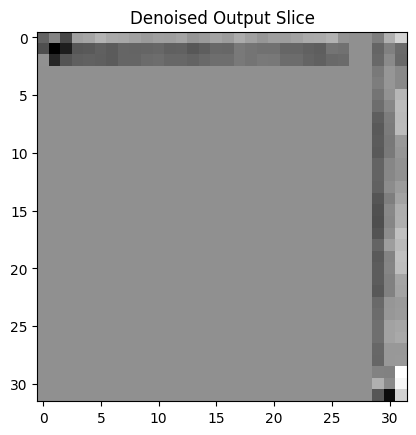

In [79]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    sample_input = X_noisy[0:1]
    sample_input_tensor = sample_input.clone().detach().to(device)
    denoised = model(sample_input_tensor).cpu().numpy()[0, 0]

# Visualize middle slice
plt.imshow(denoised[:, :, 16], cmap='gray')
plt.title("Denoised Output Slice")
plt.show()

In [77]:
# evaluate model

def evaluate_model(model, test_loader, device):
    """
    Evaluates the model on test data, computes binary accuracy, and visualizes results.
    """
    model.eval()
    total_accuracy = 0
    num_samples = 0

    with torch.no_grad():
        for noisy_batch, clean_batch in test_loader:
            noisy_batch = noisy_batch.to(device)
            clean_batch = clean_batch.to(device)

            # Predict
            output = model(noisy_batch)
            preds = (output > 0.5).float()

            # Binary accuracy
            correct = (preds == clean_batch).float().sum()
            total_voxels = torch.numel(clean_batch)
            total_accuracy += correct
            num_samples += 1

            # Visualize middle slice from first sample
            if num_samples == 1:
                slice_idx = clean_batch.shape[4] // 2
                plt.figure(figsize=(12, 4))
                plt.subplot(131)
                plt.imshow(noisy_batch[0, 0, :, :, slice_idx].cpu(), cmap='gray')
                plt.title("Noisy Input")

                plt.subplot(132)
                plt.imshow(preds[0, 0, :, :, slice_idx].cpu(), cmap='gray')
                plt.title("Denoised Prediction")

                plt.subplot(133)
                plt.imshow(clean_batch[0, 0, :, :, slice_idx].cpu(), cmap='gray')
                plt.title("Ground Truth")
                plt.show()

    avg_accuracy = total_accuracy / (num_samples * total_voxels)
    print(f"Binary Accuracy: {avg_accuracy.item():.4f}")


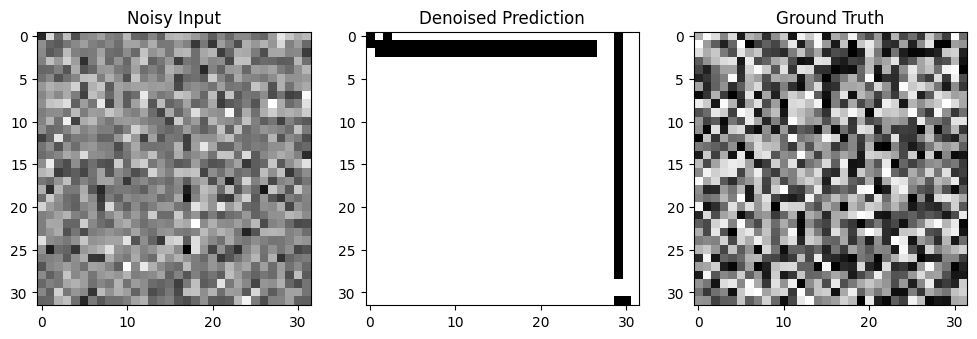

Binary Accuracy: 0.0000


In [81]:
evaluate_model(model, test_loader, device)
